# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

In [0]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!git clone https://github.com/kenshiro-o/CarND-Advanced-Lane-Lines.git
%cd /CarND-Advanced-Lane-Lines

Cloning into 'CarND-Advanced-Lane-Lines'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 178.42 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (59/59), done.
[Errno 2] No such file or directory: '/CarND-Advanced-Lane-Lines'
/content


In [6]:
%cd /content/CarND-Advanced-Lane-Lines
from importlib import reload
import utils; reload(utils)
from utils import *

/content/CarND-Advanced-Lane-Lines


In [0]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [0]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

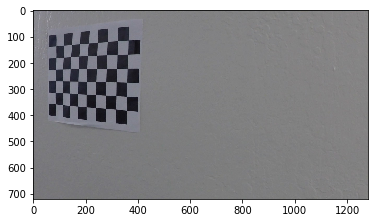

In [9]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [0]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [0]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [0]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

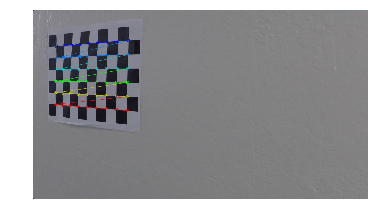

In [13]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [0]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [0]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [0]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

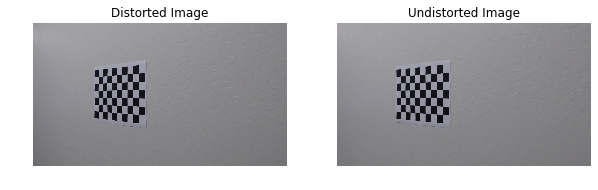

In [17]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

We can see that the undistortion step indeed works well. Let's apply the undistortion step to our test images.

#### Undistorting Test Images

In [0]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [0]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [0]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [0]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

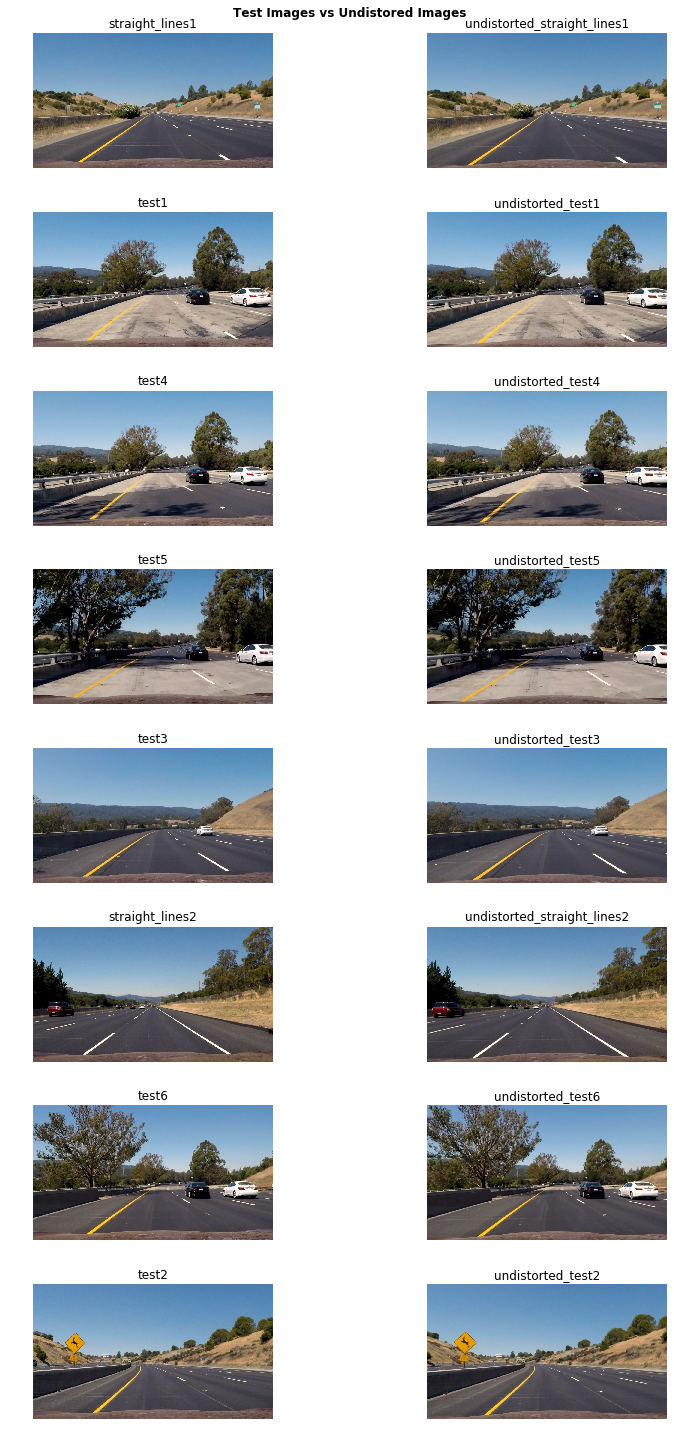

In [22]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images. We can see that on the undistorted images, the front of the car, especially at the sides, is less visible.

## Thresholding

We apply color and edge  thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later. 

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [0]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [0]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [0]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [0]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [0]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [0]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [0]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

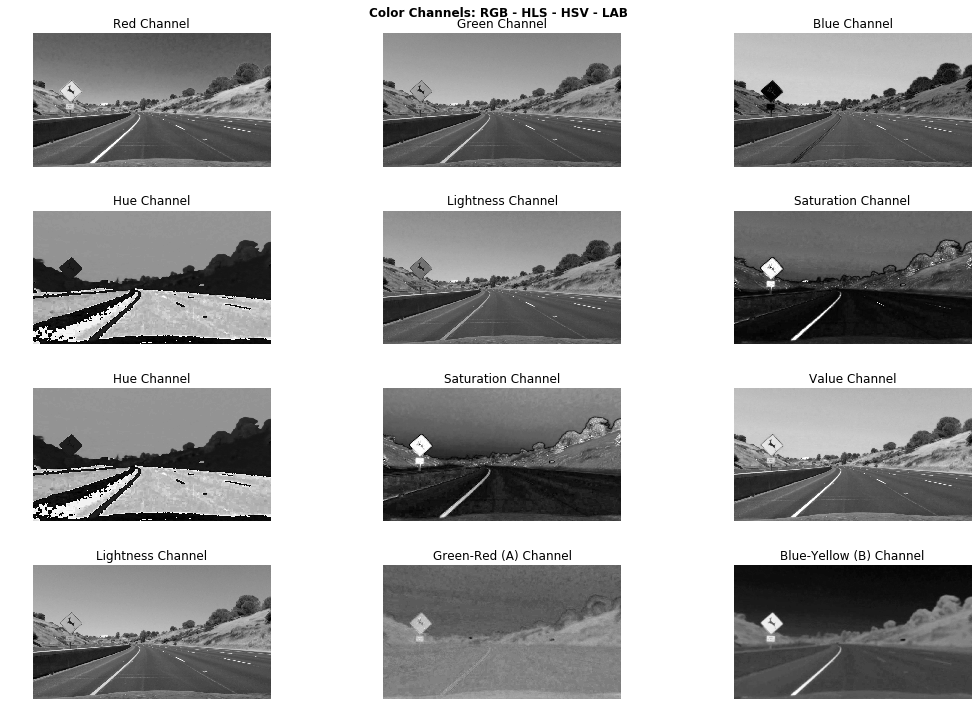

In [30]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

Lastly, LAB's A channel is not doing a great job, while it's B channel is strong at identifying the yellow line. But it is the lightness channel that shines (no pun intended) at identify both yellow and white lines.

At this stage, we are faced with various choices that have pros and cons. Our goal here is to find the right thresholds on a given color channel to highlight yellow and white lines of the lane. There are actually many ways we could achieve this result, but **we choose to use HLS because we already know how to set thresholds for yellow and white lane lines from [Project 1](https://github.com/kenshiro-o/CarND-LaneLines-P1)** .

In [0]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

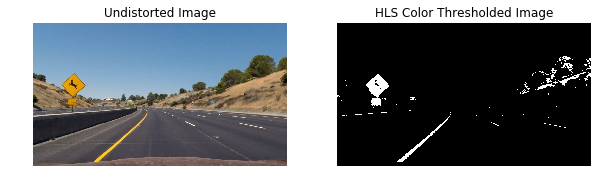

In [32]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

We have decided to use LAB's L channel as our single-channel image to serve as input to the sobel functions below.

In [0]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [0]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [0]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [0]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

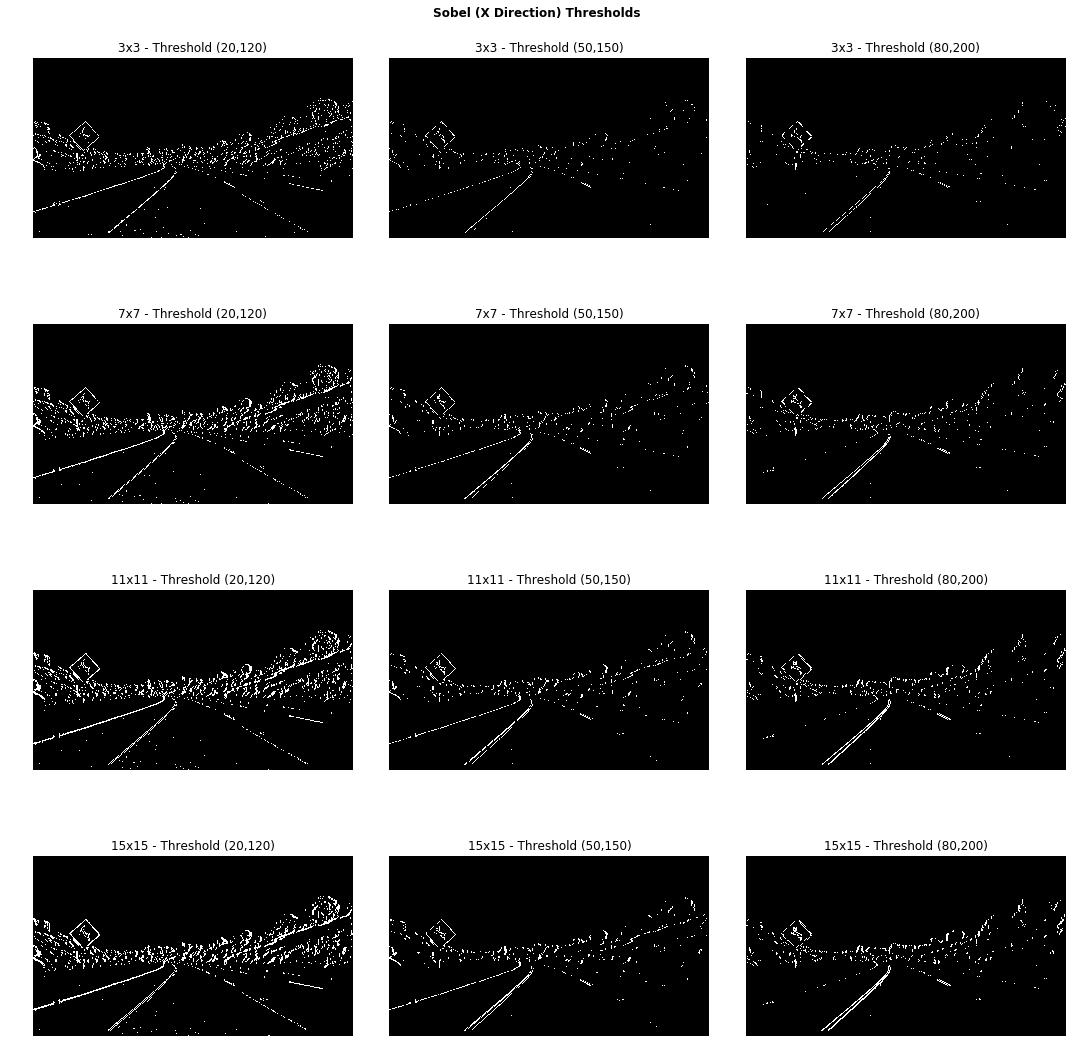

In [37]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [0]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [0]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [0]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

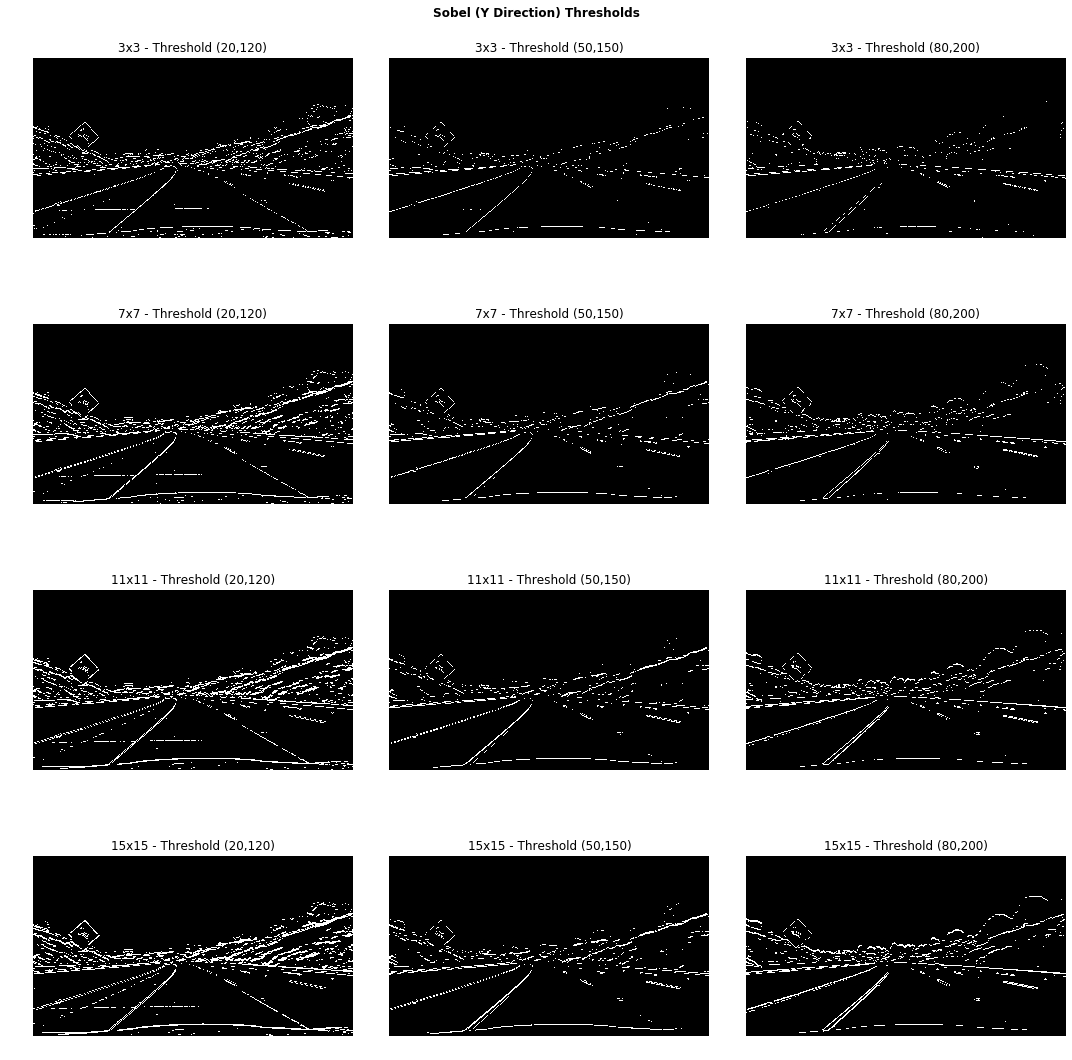

In [41]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [0]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [0]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [0]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [0]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


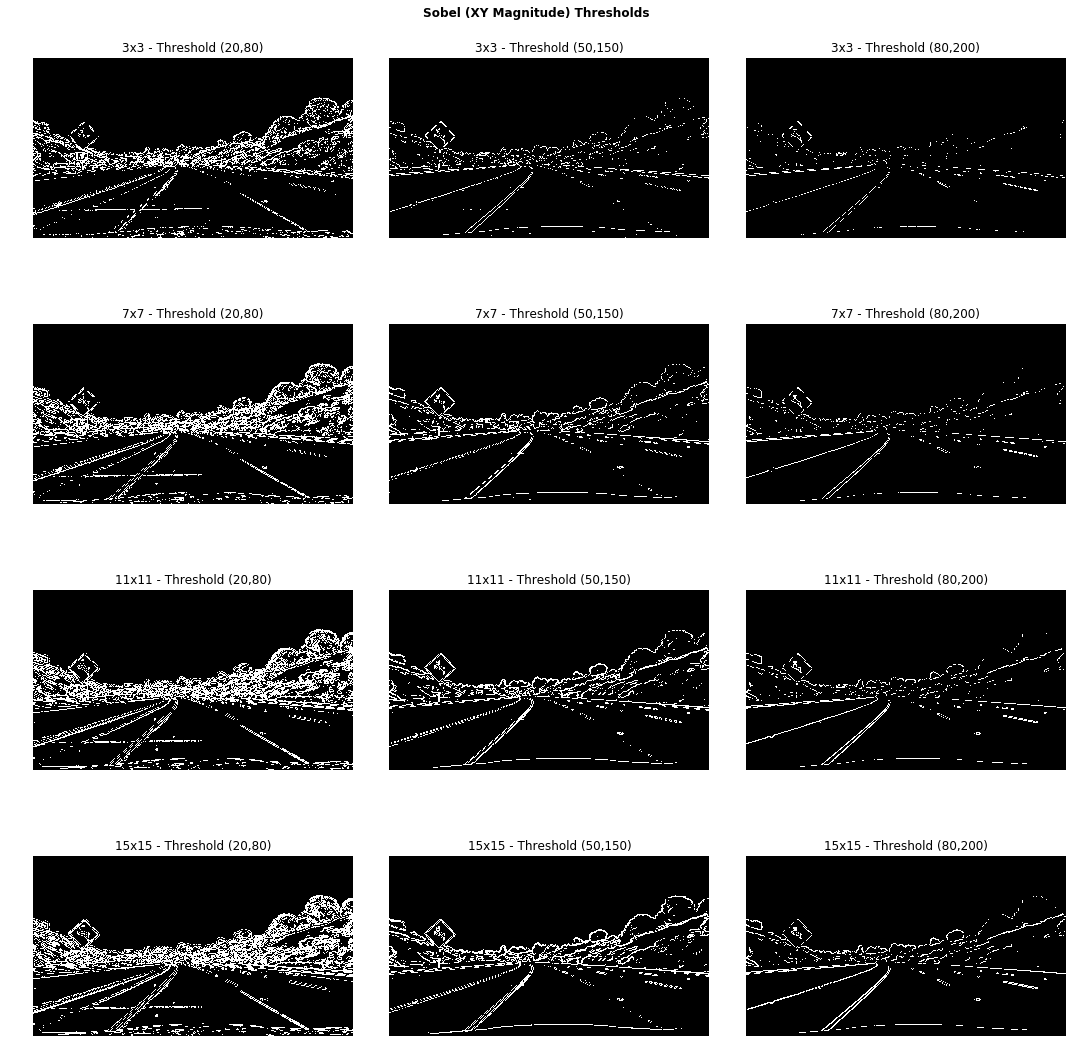

In [46]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [0]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [0]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [0]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [0]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [0]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [0]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

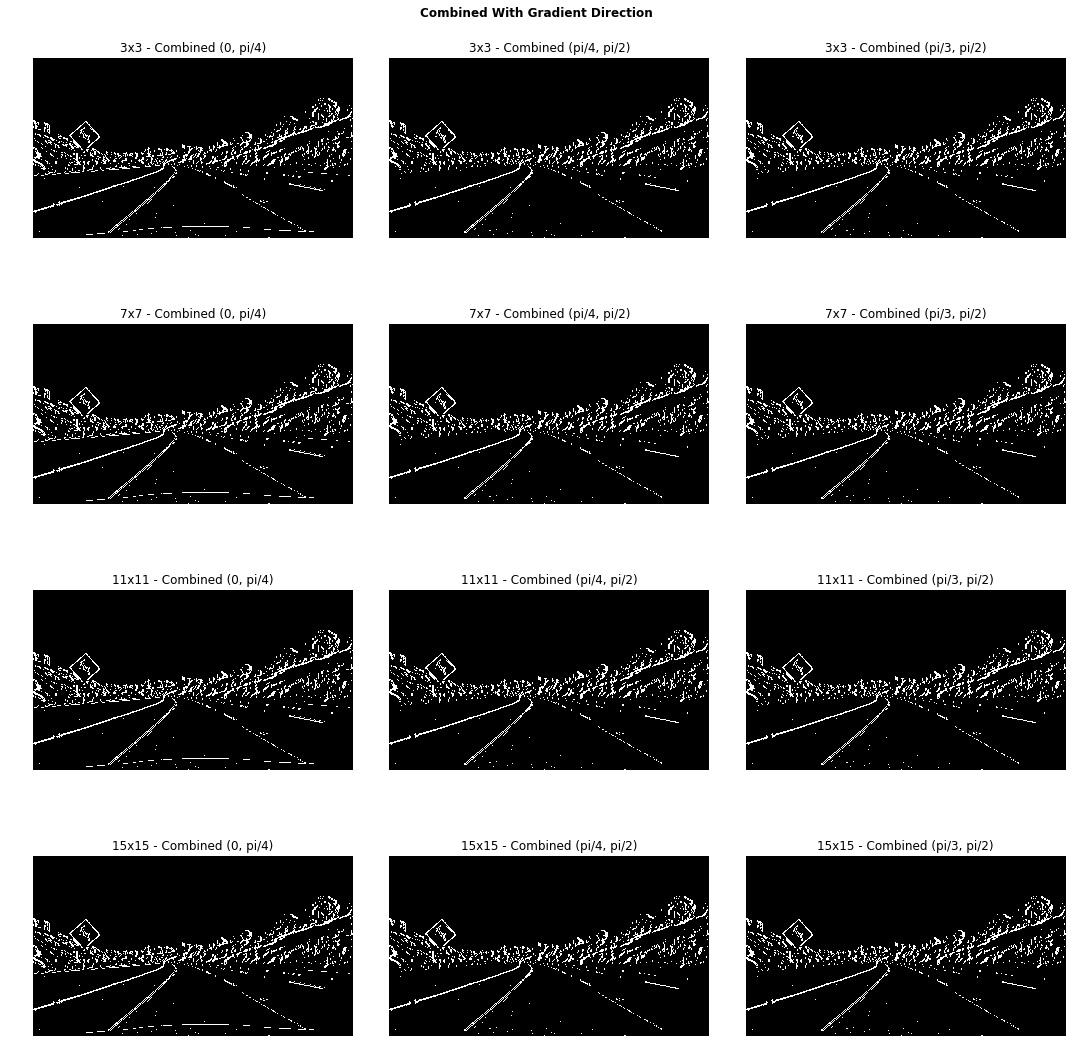

In [58]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [0]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.

### Combining Color And Gradient (Sobel) Thresholds

In [0]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [0]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [0]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

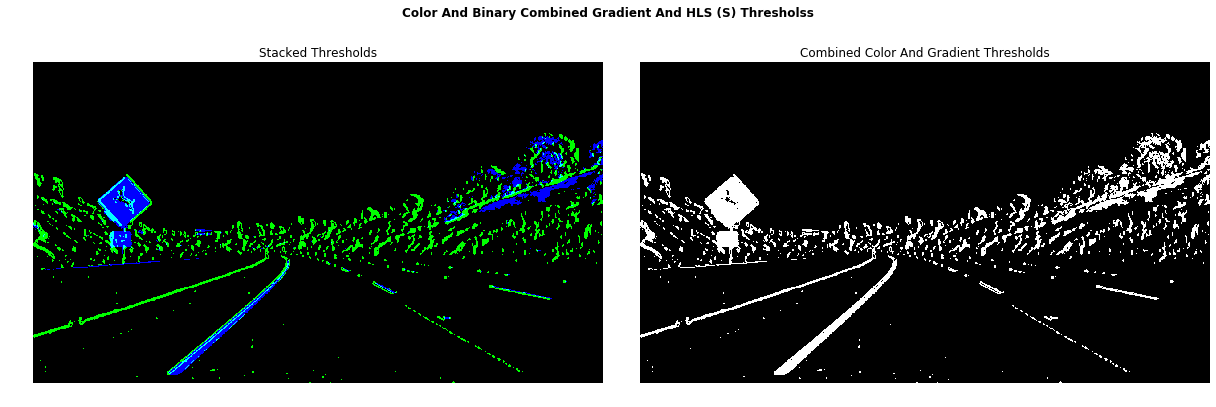

In [67]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a _bird's eye view_ of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

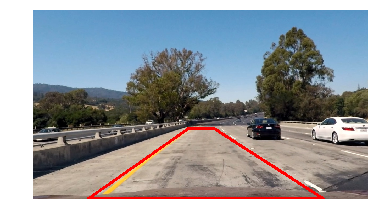

In [68]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [0]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [0]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [0]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [0]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

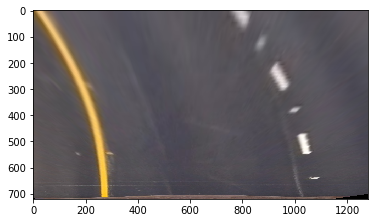

In [73]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [0]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

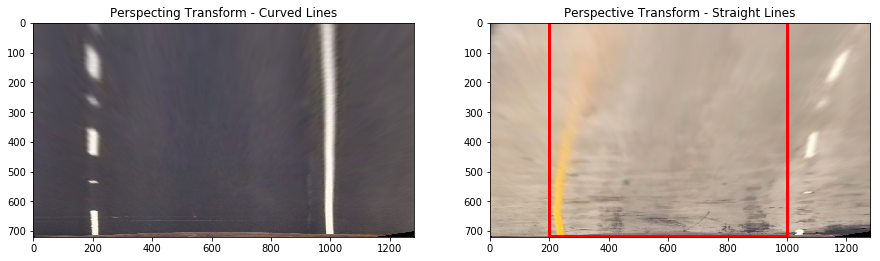

In [75]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check. The curved lines however are not perfect on the example above, but they should not cause unsurmountable problems for our algorithm either. 

In [0]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

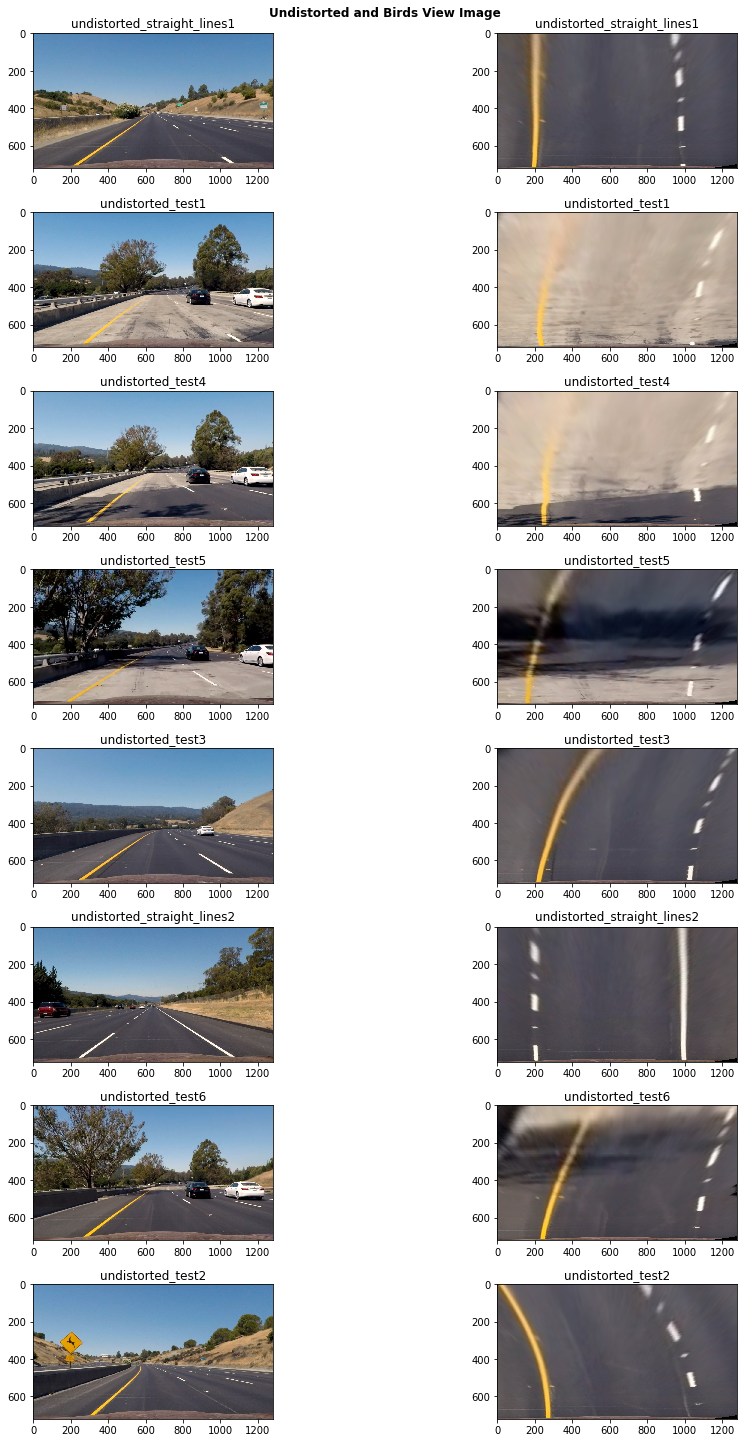

In [77]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

### Putting It All Together

In [0]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [0]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [0]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [0]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [0]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

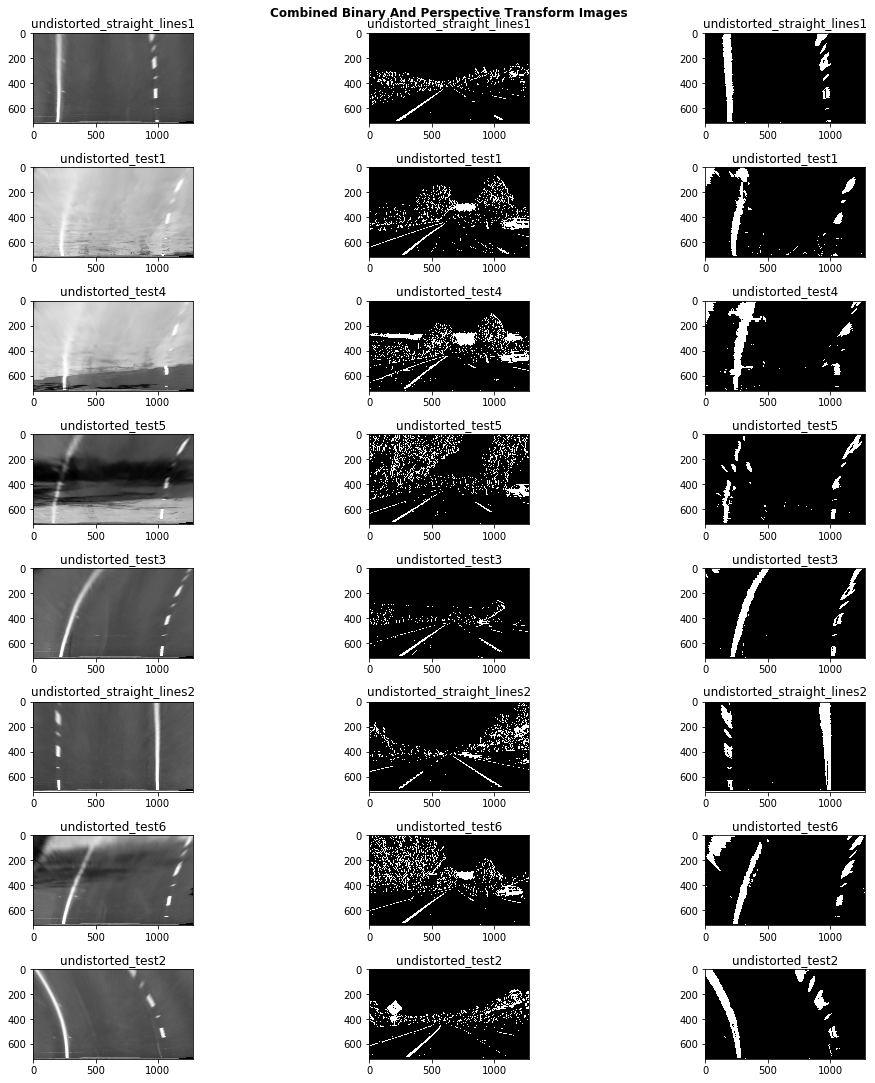

In [83]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

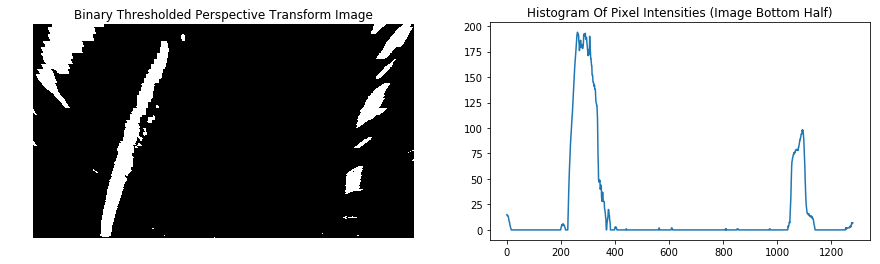

In [84]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames. 

In [0]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [0]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [0]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [0]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [0]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [105]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=34353.687798020204
Left Curvature   Right Curvature  Center Alignment 
476.1846m        354.5999m        0.2519m Right    


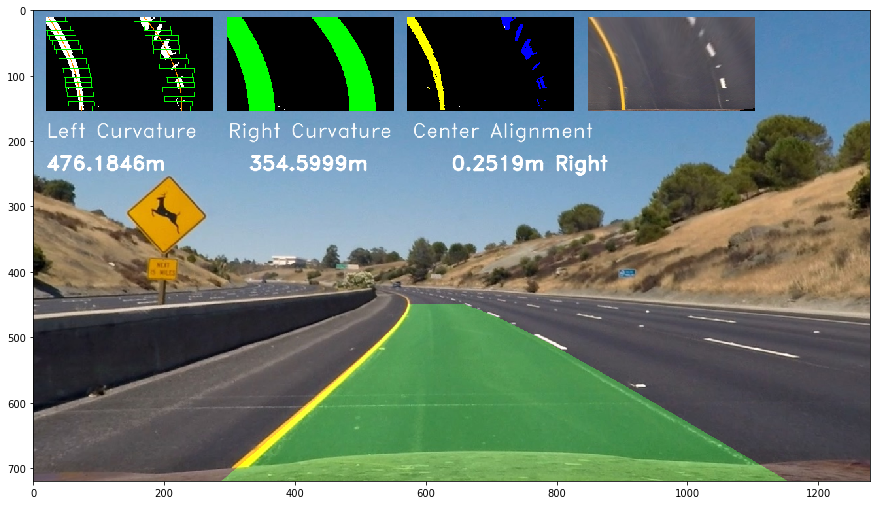

In [106]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [0]:
#(720, 1280, 3)

# Normal video

In [92]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2727936/45929032 bytes (5.9%)6103040/45929032 bytes (13.3%)9633792/45929032 bytes (21.0%)13115392/45929032 bytes (28.6%)16203776/45929032 bytes (35.3%)19447808/45929032 bytes (42.3%)22683648/45929032 bytes (49.4%)25968640/45929032 bytes (56.5%)29212672/45929032 bytes (63.6%)32481280/45929032 bytes (70.7%)35741696/45929032 bytes (77.8%)37142528/45929032 bytes (80.9%)

In [0]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = '/content/CarND-Advanced-Lane-Lines/project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = '/content/CarND-Advanced-Lane-Lines/output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [94]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -y -i project_video.mp4 -ss 22.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [0]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

In [101]:

import io
import base64
from IPython.display import HTML

video = io.open(video_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" autoplay 
                loop controls controls style="height: 400px;" >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [0]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

In [0]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

# Challege Videos

In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


In [0]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18076.300591975443
Left Curvature   Right Curvature  Center Alignment 
100.2318m        172.5191m        0.4996m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4



  1%|          | 1/121 [00:01<02:17,  1.15s/it]

[Previous lane] Found pct=0.8632553589799807
Left Curvature   Right Curvature  Center Alignment 
108.4391m        166.6905m        0.6366m Left     



  2%|▏         | 2/121 [00:02<02:11,  1.10s/it]

[Previous lane] Found pct=0.8634667403794895
Left Curvature   Right Curvature  Center Alignment 
105.4820m        167.4809m        0.6258m Left     



  2%|▏         | 3/121 [00:03<02:06,  1.07s/it]

[Previous lane] Found pct=0.8514568212895761
Left Curvature   Right Curvature  Center Alignment 
109.8837m        168.7852m        0.6514m Left     



  3%|▎         | 4/121 [00:04<01:59,  1.02s/it]

[Previous lane] Found pct=0.8438962143768609
Non zeros found below thresholds, begining sliding window - pct=0.8438962143768609
[Sliding windows] Found pct=12789.78250389905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 963.8389593   360.3163162    56.24132871  -88.95087923] - y_new=[ 485.13901969  515.98167007  434.52683871  258.73516142] - distance=478.6999396176291 - max-distance=150
**** REVISED Poly left [  1.98603474e-03  -3.10920273e+00   1.11433401e+03]
Left Curvature   Right Curvature  Center Alignment 
107.6363m        169.6685m        0.6368m Left     



  4%|▍         | 5/121 [00:04<01:56,  1.00s/it]

[Previous lane] Found pct=0.8377615752183226
Non zeros found below thresholds, begining sliding window - pct=0.8377615752183226
[Sliding windows] Found pct=12463.625453122426
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.42554826  361.90997427   56.84010804  -90.94745335] - y_new=[ 474.12142652  522.52173916  442.47485657  256.85718935] - distance=490.3041217404026 - max-distance=150
**** REVISED Poly left [  1.96602881e-03  -3.09817238e+00   1.11441910e+03]
Left Curvature   Right Curvature  Center Alignment 
108.7480m        184.5238m        0.6500m Left     



  5%|▍         | 6/121 [00:05<01:53,  1.02it/s]

[Previous lane] Found pct=0.8379259570887674
Non zeros found below thresholds, begining sliding window - pct=0.8379259570887674
[Sliding windows] Found pct=14401.750333052867
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.13225378  361.11314524   56.54071837  -89.94916629] - y_new=[ 703.48386219  523.07713799  403.43639926  305.73756332] - distance=395.6867296085694 - max-distance=150
**** REVISED Poly left [  1.97603178e-03  -3.10368756e+00   1.11437655e+03]
Left Curvature   Right Curvature  Center Alignment 
108.1892m        325.6592m        0.6827m Left     



  6%|▌         | 7/121 [00:06<01:50,  1.03it/s]

[Previous lane] Found pct=0.8256089193825042
Non zeros found below thresholds, begining sliding window - pct=0.8256089193825042
[Sliding windows] Found pct=14285.87629502573
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.27890102  361.51155975   56.6904132   -90.44830982] - y_new=[ 751.28499117  528.73383595  401.70457919  320.01902681] - distance=410.4673366319171 - max-distance=150
**** REVISED Poly left [  1.97103029e-03  -3.10092997e+00   1.11439782e+03]
Left Curvature   Right Curvature  Center Alignment 
108.4679m        604.1720m        0.7093m Left     



  7%|▋         | 8/121 [00:07<01:49,  1.03it/s]

[Previous lane] Found pct=0.8249382280268267
Non zeros found below thresholds, begining sliding window - pct=0.8249382280268267
[Sliding windows] Found pct=13586.2050653018
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2055774   361.3123525    56.61556579  -90.19873806] - y_new=[ 733.89481813  539.84191911  414.79788909  316.59678281] - distance=406.79552086725573 - max-distance=150
**** REVISED Poly left [  1.97353104e-03  -3.10230876e+00   1.11438719e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3284m        670.8350m        0.7106m Left     



  7%|▋         | 9/121 [00:08<01:46,  1.05it/s]

[Previous lane] Found pct=0.8174759632012174
Non zeros found below thresholds, begining sliding window - pct=0.8174759632012174
[Sliding windows] Found pct=14873.896503423946
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.24223921  361.41195612   56.6529895   -90.32352394] - y_new=[ 810.93409043  553.67106313  409.74336045  320.82251926] - distance=411.1460432039976 - max-distance=150
**** REVISED Poly left [  1.97228066e-03  -3.10161937e+00   1.11439251e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3981m        628.7913m        0.7114m Left     



  8%|▊         | 10/121 [00:09<01:45,  1.05it/s]

[Previous lane] Found pct=0.8158317141167526
Non zeros found below thresholds, begining sliding window - pct=0.8158317141167526
[Sliding windows] Found pct=15061.599459322464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2239083   361.36215431   56.63427764  -90.261131  ] - y_new=[ 820.04321379  555.76804051  410.1230431   322.94483787] - distance=413.20596887130625 - max-distance=150
**** REVISED Poly left [  1.97290585e-03  -3.10196406e+00   1.11438985e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3632m        294.2097m        0.6753m Left     



  9%|▉         | 11/121 [00:10<01:43,  1.06it/s]

[Previous lane] Found pct=0.8422020535699082
Non zeros found below thresholds, begining sliding window - pct=0.8422020535699082
[Sliding windows] Found pct=14822.618948694808
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.23307376  361.38705522   56.64363357  -90.29232747] - y_new=[ 779.91592491  572.50611378  428.35579088  303.56326887] - distance=393.8555963343688 - max-distance=150
**** REVISED Poly left [  1.97259326e-03  -3.10179171e+00   1.11439118e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1245.24777518  1096.37320026  1025.22415744   996.69788539] - y_new=[ 1407.08327748  1120.29669477  1016.18958247  1023.47994027] - distance=161.83550229886214 - max-distance=150
**** REVISED Poly right [  5.32784635e-04  -7.81972922e-01   1.28301446e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3806m        400.8144m        0.6934m Left     



 10%|▉         | 12/121 [00:11<01:41,  1.07it/s]

[Previous lane] Found pct=0.8326522824479672
Non zeros found below thresholds, begining sliding window - pct=0.8326522824479672
[Sliding windows] Found pct=20161.812586456363
Left Curvature   Right Curvature  Center Alignment 
138.0546m        161.1714m        0.6060m Left     



 11%|█         | 13/121 [00:12<01:40,  1.07it/s]

[Previous lane] Found pct=0.8416899176173417
Non zeros found below thresholds, begining sliding window - pct=0.8416899176173417
[Sliding windows] Found pct=20324.354674679304
Left Curvature   Right Curvature  Center Alignment 
143.0593m        165.0102m        0.6179m Left     



 12%|█▏        | 14/121 [00:13<01:40,  1.06it/s]

[Previous lane] Found pct=0.8391650099403578
Non zeros found below thresholds, begining sliding window - pct=0.8391650099403578
[Sliding windows] Found pct=19777.676494876894
Left Curvature   Right Curvature  Center Alignment 
141.5839m        166.2785m        0.5865m Left     



 12%|█▏        | 15/121 [00:14<01:40,  1.06it/s]

[Previous lane] Found pct=0.8346157807235651
Non zeros found below thresholds, begining sliding window - pct=0.8346157807235651
[Sliding windows] Found pct=22334.715796907414
Left Curvature   Right Curvature  Center Alignment 
155.9016m        173.1657m        0.6531m Left     



 13%|█▎        | 16/121 [00:15<01:39,  1.06it/s]

[Previous lane] Found pct=0.8362188935609858
Non zeros found below thresholds, begining sliding window - pct=0.8362188935609858
[Sliding windows] Found pct=22040.199290705852
Left Curvature   Right Curvature  Center Alignment 
161.2186m        168.1447m        0.6718m Left     



 14%|█▍        | 17/121 [00:16<01:38,  1.06it/s]

[Previous lane] Found pct=0.8326120421737488
Non zeros found below thresholds, begining sliding window - pct=0.8326120421737488
[Sliding windows] Found pct=22756.522321298904
Left Curvature   Right Curvature  Center Alignment 
171.5417m        177.5921m        0.6904m Left     



 15%|█▍        | 18/121 [00:17<01:36,  1.07it/s]

[Previous lane] Found pct=0.8240575908054593
Non zeros found below thresholds, begining sliding window - pct=0.8240575908054593
[Sliding windows] Found pct=17138.186951497548
**** MAX DISTANCE BREACHED ****
y_smooth=[ 852.26613141  351.36999365   66.9492258  -114.09719327] - y_new=[ 775.80591965  528.11227653  400.65660607  336.04470808] - distance=450.1419013447488 - max-distance=150
**** REVISED Poly left [  1.29217936e-03  -2.45584733e+00   9.71828049e+02]
Left Curvature   Right Curvature  Center Alignment 
166.2209m        172.7165m        0.6885m Left     



 16%|█▌        | 19/121 [00:18<01:35,  1.07it/s]

[Previous lane] Found pct=0.8387592298427218
Non zeros found below thresholds, begining sliding window - pct=0.8387592298427218
[Sliding windows] Found pct=19730.40178399986
Left Curvature   Right Curvature  Center Alignment 
182.2416m        181.1659m        0.7375m Left     



 17%|█▋        | 20/121 [00:19<01:34,  1.07it/s]

[Previous lane] Found pct=0.8338032626521277
Non zeros found below thresholds, begining sliding window - pct=0.8338032626521277
[Sliding windows] Found pct=18842.81829559513
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.53028523  354.13011642   65.91605768 -123.35926657] - y_new=[ 774.24743504  527.48993997  401.34868773  338.55387444] - distance=461.9131410017587 - max-distance=150
**** REVISED Poly left [  1.23673418e-03  -2.43045764e+00   9.71961332e+02]
Left Curvature   Right Curvature  Center Alignment 
173.8638m        177.8355m        0.7077m Left     



 17%|█▋        | 21/121 [00:19<01:33,  1.07it/s]

[Previous lane] Found pct=0.8356637907830053
Non zeros found below thresholds, begining sliding window - pct=0.8356637907830053
[Sliding windows] Found pct=18335.327652400585
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.16236214  355.5101778    65.39947361 -127.99030322] - y_new=[ 778.30499422  546.45512498  413.22025432  326.42540564] - distance=454.41570885798626 - max-distance=150
**** REVISED Poly left [  1.20901159e-03  -2.41776279e+00   9.72027973e+02]
Left Curvature   Right Curvature  Center Alignment 
177.9545m        178.1594m        0.7121m Left     



 18%|█▊        | 22/121 [00:20<01:32,  1.07it/s]

[Previous lane] Found pct=0.828759940575024
Non zeros found below thresholds, begining sliding window - pct=0.828759940575024
[Sliding windows] Found pct=18240.20047190422
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.84632369  354.82014711   65.65776564 -125.67478489] - y_new=[ 797.5530936   527.3698339   397.77440366  345.11335344] - distance=470.7881383332551 - max-distance=150
**** REVISED Poly left [  1.22287289e-03  -2.42411022e+00   9.71994652e+02]
Left Curvature   Right Curvature  Center Alignment 
175.8854m        176.8485m        0.7080m Left     



 19%|█▉        | 23/121 [00:21<01:31,  1.07it/s]

[Previous lane] Found pct=0.8323692817458617
Non zeros found below thresholds, begining sliding window - pct=0.8323692817458617
[Sliding windows] Found pct=18940.882714197982
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.00434292  355.16516246   65.52861963 -126.83254405] - y_new=[ 754.90063392  523.21857598  401.81032781  337.23532248] - distance=464.06786653196 - max-distance=150
**** REVISED Poly left [  1.21594224e-03  -2.42093651e+00   9.72011313e+02]
Left Curvature   Right Curvature  Center Alignment 
176.9140m        198.0882m        0.7154m Left     



 20%|█▉        | 24/121 [00:22<01:30,  1.07it/s]

[Previous lane] Found pct=0.8296094071712904
Non zeros found below thresholds, begining sliding window - pct=0.8296094071712904
[Sliding windows] Found pct=17411.634892552654
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9253333   354.99265478   65.59319264 -126.25366447] - y_new=[ 790.61323944  532.5467942   403.18470427  342.34800659] - distance=468.6016710593858 - max-distance=150
**** REVISED Poly left [  1.21940756e-03  -2.42252336e+00   9.72002982e+02]
Left Curvature   Right Curvature  Center Alignment 
176.3982m        194.5637m        0.7146m Left     



 21%|██        | 25/121 [00:23<01:29,  1.07it/s]

[Previous lane] Found pct=0.8248164633793861
Non zeros found below thresholds, begining sliding window - pct=0.8248164633793861
[Sliding windows] Found pct=18703.25696572056
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.96483811  355.07890862   65.56090613 -126.54310426] - y_new=[ 801.8041542   540.03531791  407.0701205   342.06036454] - distance=468.6034688024231 - max-distance=150
**** REVISED Poly left [  1.21767490e-03  -2.42172993e+00   9.72007148e+02]
Left Curvature   Right Curvature  Center Alignment 
176.6557m        201.2027m        0.7194m Left     



 21%|██▏       | 26/121 [00:24<01:26,  1.10it/s]

[Previous lane] Found pct=0.6389604342195253
Non zeros found below thresholds, begining sliding window - pct=0.6389604342195253
[Sliding windows] Found pct=17798.178766315974
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.94508571  355.0357817    65.57704938 -126.39838437] - y_new=[ 809.12451757  581.63959536  434.90091287  319.49490173] - distance=445.89328609794677 - max-distance=150
**** REVISED Poly left [  1.21854123e-03  -2.42212665e+00   9.72005065e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5269m        200.6158m        0.7222m Left     



 22%|██▏       | 27/121 [00:25<01:26,  1.09it/s]

[Previous lane] Found pct=0.6800420977735614
Non zeros found below thresholds, begining sliding window - pct=0.6800420977735614
[Sliding windows] Found pct=17593.88805549791
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95496191  355.05734516   65.56897776 -126.47074431] - y_new=[ 801.22875237  577.75705785  432.80893074  317.93122896] - distance=444.4019732719438 - max-distance=150
**** REVISED Poly left [  1.21810807e-03  -2.42192829e+00   9.72006106e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5913m        219.0953m        0.7262m Left     



 23%|██▎       | 28/121 [00:26<01:28,  1.05it/s]

[Previous lane] Found pct=0.5647311054138743
Non zeros found below thresholds, begining sliding window - pct=0.5647311054138743
[Sliding windows] Found pct=17026.731285326616
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95002381  355.04656343   65.57301357 -126.43456434] - y_new=[ 860.54986777  579.97823016  425.97472535  334.59682522] - distance=461.031389558181 - max-distance=150
**** REVISED Poly left [  1.21832465e-03  -2.42202747e+00   9.72005586e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5591m        214.9469m        0.7303m Left     



 24%|██▍       | 29/121 [00:27<01:28,  1.04it/s]

[Previous lane] Found pct=0.5451624788151205
Non zeros found below thresholds, begining sliding window - pct=0.5451624788151205
[Sliding windows] Found pct=17320.020440645494
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95249286  355.0519543    65.57099566 -126.45265433] - y_new=[ 854.22626295  579.95033549  427.57110514  334.78432955] - distance=461.2369838815158 - max-distance=150
**** REVISED Poly left [  1.21821636e-03  -2.42197788e+00   9.72005846e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5752m        238.4228m        0.7366m Left     



 25%|██▍       | 30/121 [00:28<01:27,  1.04it/s]

[Previous lane] Found pct=0.5511530965015863
Non zeros found below thresholds, begining sliding window - pct=0.5511530965015863
[Sliding windows] Found pct=18013.02825477671
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95125833  355.04925886   65.57200462 -126.44360933] - y_new=[ 853.1802195   573.47534773  422.89964391  337.38011217] - distance=463.8237215048616 - max-distance=150
**** REVISED Poly left [  1.21827050e-03  -2.42200267e+00   9.72005716e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5671m        260.4122m        0.7398m Left     



 26%|██▌       | 31/121 [00:29<01:26,  1.04it/s]

[Previous lane] Found pct=0.5633924458774758
Non zeros found below thresholds, begining sliding window - pct=0.5633924458774758
[Sliding windows] Found pct=18097.972708429294
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95187559  355.05060658   65.57150014 -126.44813183] - y_new=[ 855.46517598  580.8171705   426.53977475  330.43216447] - distance=456.880296303489 - max-distance=150
**** REVISED Poly left [  1.21824343e-03  -2.42199028e+00   9.72005781e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5711m        284.1023m        0.7383m Left     



 26%|██▋       | 32/121 [00:30<01:24,  1.05it/s]

[Previous lane] Found pct=0.5848071319350279
Non zeros found below thresholds, begining sliding window - pct=0.5848071319350279
[Sliding windows] Found pct=17580.5407230028
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95156696  355.04993272   65.57175238 -126.44587058] - y_new=[ 865.4432076   575.62319632  422.30882876  338.80925362] - distance=465.2551242069885 - max-distance=150
**** REVISED Poly left [  1.21825697e-03  -2.42199648e+00   9.72005748e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5691m        321.2191m        0.7315m Left     



 27%|██▋       | 33/121 [00:31<01:23,  1.05it/s]

[Previous lane] Found pct=0.6015271651125133
Non zeros found below thresholds, begining sliding window - pct=0.6015271651125133
[Sliding windows] Found pct=17897.515090178124
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95172128  355.05026965   65.57162626 -126.44700121] - y_new=[ 851.50923046  575.07450966  425.35218793  339.11915946] - distance=465.5661606627268 - max-distance=150
**** REVISED Poly left [  1.21825020e-03  -2.42199338e+00   9.72005765e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5701m        283.6088m        0.7021m Left     



 28%|██▊       | 34/121 [00:32<01:22,  1.05it/s]

[Previous lane] Found pct=0.5930700128333096
Non zeros found below thresholds, begining sliding window - pct=0.5930700128333096
[Sliding windows] Found pct=17266.32054755454
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95164412  355.05010119   65.57168932 -126.44643589] - y_new=[ 854.93888648  573.61031798  424.23884024  342.14858654] - distance=468.5950224381462 - max-distance=150
**** REVISED Poly left [  1.21825358e-03  -2.42199493e+00   9.72005756e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5696m        218.9061m        0.6526m Left     



 29%|██▉       | 35/121 [00:33<01:21,  1.06it/s]

[Previous lane] Found pct=0.5827356667382435
Non zeros found below thresholds, begining sliding window - pct=0.5827356667382435
[Sliding windows] Found pct=16520.200787345217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9516827   355.05018542   65.57165779 -126.44671855] - y_new=[ 853.31368617  596.61121368  440.81499498  329.07722901] - distance=455.5239475560055 - max-distance=150
**** REVISED Poly left [  1.21825189e-03  -2.42199415e+00   9.72005761e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5699m        184.1812m        0.6059m Left     



 30%|██▉       | 36/121 [00:34<01:19,  1.07it/s]

[Previous lane] Found pct=0.409255366310581
Non zeros found below thresholds, begining sliding window - pct=0.409255366310581
[Sliding windows] Found pct=15582.451771132753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166341  355.0501433    65.57167356 -126.44657722] - y_new=[ 872.04495405  621.04423384  456.40155668  323.89923418] - distance=450.345811406233 - max-distance=150
**** REVISED Poly left [  1.21825274e-03  -2.42199454e+00   9.72005758e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5697m        163.9744m        0.5894m Left     



 31%|███       | 37/121 [00:35<01:19,  1.06it/s]

[Previous lane] Found pct=0.30505243088655865
Non zeros found below thresholds, begining sliding window - pct=0.30505243088655865
[Sliding windows] Found pct=14891.836210310186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167306  355.05016436   65.57166567 -126.44664789] - y_new=[ 910.88841112  631.31086753  457.57003356  328.2036004 ] - distance=454.65024829035565 - max-distance=150
**** REVISED Poly left [  1.21825231e-03  -2.42199434e+00   9.72005760e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        162.3235m        0.5896m Left     



 31%|███▏      | 38/121 [00:35<01:17,  1.07it/s]

[Previous lane] Found pct=0.24840734712857476
Non zeros found below thresholds, begining sliding window - pct=0.24840734712857476
[Sliding windows] Found pct=13994.472897775711
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166823  355.05015383   65.57166961 -126.44661255] - y_new=[ 941.15869013  616.06323226  440.87158978  341.13303515] - distance=467.5796477021087 - max-distance=150
**** REVISED Poly left [  1.21825253e-03  -2.42199444e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        158.5928m        0.5882m Left     



 32%|███▏      | 39/121 [00:36<01:15,  1.08it/s]

[Previous lane] Found pct=0.2480873995976564
Non zeros found below thresholds, begining sliding window - pct=0.2480873995976564
[Sliding windows] Found pct=17714.296030895286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167064  355.0501591    65.57166764 -126.44663022] - y_new=[ 1013.3431606    475.40400828   295.10363247   337.07076427] - distance=463.51739448678325 - max-distance=150
**** REVISED Poly left [  1.21825242e-03  -2.42199439e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        169.9762m        0.5930m Left     



 33%|███▎      | 40/121 [00:37<01:15,  1.07it/s]

[Previous lane] Found pct=0.2348973212282565
Non zeros found below thresholds, begining sliding window - pct=0.2348973212282565
[Sliding windows] Found pct=17765.35193466848
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166944  355.05015646   65.57166863 -126.44662139] - y_new=[ 1015.69553131   470.17557316   282.34818596   315.48842483] - distance=441.9350462224422 - max-distance=150
**** REVISED Poly left [  1.21825247e-03  -2.42199442e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        181.1805m        0.5945m Left     



 34%|███▍      | 41/121 [00:38<01:15,  1.07it/s]

[Previous lane] Found pct=0.36897277719703775
Non zeros found below thresholds, begining sliding window - pct=0.36897277719703775
[Sliding windows] Found pct=17587.894465629186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167004  355.05015778   65.57166814 -126.4466258 ] - y_new=[ 965.43377723  461.41729644  284.81191267  309.6356852 ] - distance=436.082311006076 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        217.4164m        0.6002m Left     



 35%|███▍      | 42/121 [00:39<01:14,  1.06it/s]

[Previous lane] Found pct=0.34889368184491937
Non zeros found below thresholds, begining sliding window - pct=0.34889368184491937
[Sliding windows] Found pct=17230.976335198564
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166974  355.05015712   65.57166838 -126.4466236 ] - y_new=[ 969.0640693   458.73307792  268.68320915  272.60216201] - distance=399.048785608372 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8726m        0.6009m Left     



 36%|███▌      | 43/121 [00:40<01:14,  1.05it/s]

[Previous lane] Found pct=0.21568446899938612
Non zeros found below thresholds, begining sliding window - pct=0.21568446899938612
[Sliding windows] Found pct=16347.84439840393
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166989  355.05015745   65.57166826 -126.4466247 ] - y_new=[ 987.94117321  476.2397197   273.6020071   254.71847245] - distance=381.16509714625977 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        222.5639m        0.5912m Left     



 36%|███▋      | 44/121 [00:41<01:13,  1.05it/s]

[Previous lane] Found pct=0.16885352004942486
Non zeros found below thresholds, begining sliding window - pct=0.16885352004942486
[Sliding windows] Found pct=16772.318731428906
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166982  355.05015729   65.57166832 -126.44662415] - y_new=[ 1001.01941714   486.03866947   277.18394219   248.88910013] - distance=375.33572427958484 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        219.2053m        0.5834m Left     



 37%|███▋      | 45/121 [00:42<01:12,  1.05it/s]

[Previous lane] Found pct=0.12644260877344704
Non zeros found below thresholds, begining sliding window - pct=0.12644260877344704
[Sliding windows] Found pct=16133.915501148123
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166985  355.05015737   65.57166829 -126.44662442] - y_new=[ 1040.88783333   507.3715782    285.45342142   245.66401781] - distance=372.110642230081 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        213.2734m        0.5814m Left     



 38%|███▊      | 46/121 [00:43<01:11,  1.05it/s]

[Previous lane] Found pct=0.1460897067280046
Non zeros found below thresholds, begining sliding window - pct=0.1460897067280046
[Sliding windows] Found pct=17629.53110983324
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166983  355.05015733   65.57166831 -126.44662429] - y_new=[ 996.33243155  492.40341842  284.69807938  250.71529274] - distance=377.1619170276879 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.6583m        0.5559m Left     



 39%|███▉      | 47/121 [00:44<01:10,  1.05it/s]

[Previous lane] Found pct=0.1542017322931384
Non zeros found below thresholds, begining sliding window - pct=0.1542017322931384
[Sliding windows] Found pct=16901.498387493088
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015735   65.5716683  -126.44662436] - y_new=[ 985.74781071  491.86590065  278.92672484  227.91319547] - distance=354.35981982453427 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.2420m        0.5418m Left     



 40%|███▉      | 48/121 [00:45<01:09,  1.05it/s]

[Previous lane] Found pct=0.16340023612750884
Non zeros found below thresholds, begining sliding window - pct=0.16340023612750884
[Sliding windows] Found pct=18632.902449822905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662432] - y_new=[ 980.26408758  487.98685436  271.56630214  212.83573601] - distance=339.28236033050143 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        224.8317m        0.5329m Left     



 40%|████      | 49/121 [00:46<01:08,  1.06it/s]

[Previous lane] Found pct=0.10594619036852815
Non zeros found below thresholds, begining sliding window - pct=0.10594619036852815
[Sliding windows] Found pct=17442.649197377345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662434] - y_new=[ 1010.24839759   508.89201378   287.39668925   225.53672696] - distance=351.9833512948742 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.1374m        0.5263m Left     



 41%|████▏     | 50/121 [00:47<01:07,  1.06it/s]

[Previous lane] Found pct=0.09665981027231142
Non zeros found below thresholds, begining sliding window - pct=0.09665981027231142
[Sliding windows] Found pct=17497.204356368773
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.39853847   515.02009237   284.53813594   214.2524466 ] - distance=340.6990709291848 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.6361m        0.5227m Left     



 42%|████▏     | 51/121 [00:48<01:06,  1.06it/s]

[Previous lane] Found pct=0.0837256332051452
Non zeros found below thresholds, begining sliding window - pct=0.0837256332051452
[Sliding windows] Found pct=16115.790329531892
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1047.69056686   527.43836622   288.75751423   207.87302537] - distance=334.3196497022045 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.6118m        0.5108m Left     



 43%|████▎     | 52/121 [00:49<01:05,  1.05it/s]

[Previous lane] Found pct=0.08129234837216989
Non zeros found below thresholds, begining sliding window - pct=0.08129234837216989
[Sliding windows] Found pct=15959.939150553628
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1057.70386008   534.10383519   292.68618641   209.01286751] - distance=335.4594918440981 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7991m        0.4995m Left     



 44%|████▍     | 53/121 [00:50<01:05,  1.04it/s]

[Previous lane] Found pct=0.07549785306150049
Non zeros found below thresholds, begining sliding window - pct=0.07549785306150049
[Sliding windows] Found pct=15840.285864015957
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1072.06965385   541.64473586   292.58859875   199.34028144] - distance=325.78690576968415 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7970m        0.4920m Left     



 45%|████▍     | 54/121 [00:51<01:04,  1.03it/s]

[Previous lane] Found pct=0.07571384808861228
Non zeros found below thresholds, begining sliding window - pct=0.07571384808861228
[Sliding windows] Found pct=16780.652193541107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1007.93939923   523.26129448   288.09122627   188.54108304] - distance=314.98770736775646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.1619m        0.4725m Left     



 45%|████▌     | 55/121 [00:52<01:04,  1.02it/s]

[Previous lane] Found pct=0.07280751023028163
Non zeros found below thresholds, begining sliding window - pct=0.07280751023028163
[Sliding windows] Found pct=17656.715333386826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.6531598    525.001196     282.4283847    163.89891539] - distance=290.34553971870014 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.2600m        0.4575m Left     



 46%|████▋     | 56/121 [00:53<01:03,  1.03it/s]

[Previous lane] Found pct=0.059412451297900674
Non zeros found below thresholds, begining sliding window - pct=0.059412451297900674
[Sliding windows] Found pct=17052.56823225764
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1014.17428347   532.67561515   286.01820637   162.50882059] - distance=288.9554449197216 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.7923m        0.4474m Left     



 47%|████▋     | 57/121 [00:54<01:01,  1.04it/s]

[Previous lane] Found pct=0.05992069320017624
Non zeros found below thresholds, begining sliding window - pct=0.05992069320017624
[Sliding windows] Found pct=16251.87402294349
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1034.72321234   543.8110859    294.37157482   172.30112157] - distance=298.7477459047558 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1540.68654619  1288.61926583  1176.16040789  1142.98596448] - y_new=[ 1000.39086709   989.33370146   947.57925135   876.5726078 ] - distance=540.2956790948082 - max-distance=150
**** REVISED Poly right [  9.91055182e-04  -1.35513844e+00   1.60596583e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.4914m        0.4525m Left     



 48%|████▊     | 58/121 [00:55<00:59,  1.05it/s]

[Previous lane] Found pct=0.061789867664750704
Non zeros found below thresholds, begining sliding window - pct=0.061789867664750704
[Sliding windows] Found pct=15966.963691351424
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1052.03270326   552.19652706   298.88586736   175.84923544] - distance=302.2958597762845 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1543.18474727  1289.93279756  1177.09232577  1144.03948774] - y_new=[ 1013.16373865   988.6422082    945.99386089   882.87340427] - distance=530.021008618014 - max-distance=150
**** REVISED Poly right [  9.97345422e-04  -1.36207870e+00   1.60879532e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.1333m        0.4499m Left     



 49%|████▉     | 59/121 [00:56<00:59,  1.04it/s]

[Previous lane] Found pct=0.05977798208873906
Non zeros found below thresholds, begining sliding window - pct=0.05977798208873906
[Sliding windows] Found pct=9132.857356897197
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 932.16745334  756.14070055  616.45763503  477.78642435] - distance=604.2330486841095 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1541.93564673  1289.2760317   1176.62636683  1143.51272611] - y_new=[ 1001.88849965   981.84303827   944.80061498   889.08614352] - distance=540.0471470752559 - max-distance=150
**** REVISED Poly right [  9.94200302e-04  -1.35860857e+00   1.60738057e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.8102m        0.4512m Left     



 50%|████▉     | 60/121 [00:57<00:58,  1.04it/s]

[Previous lane] Found pct=0.0574274105638688
Non zeros found below thresholds, begining sliding window - pct=0.0574274105638688
[Sliding windows] Found pct=9465.140603838403
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 929.69381591  750.2668897   615.82948706  489.48465182] - distance=615.9312761525227 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1542.560197    1289.60441463  1176.8593463   1143.77610692] - y_new=[ 1004.02436957   996.1748134    956.51727065   887.1904854 ] - distance=538.5358274256774 - max-distance=150
**** REVISED Poly right [  9.95772862e-04  -1.36034363e+00   1.60808795e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.4713m        0.4506m Left     



 50%|█████     | 61/121 [00:57<00:57,  1.04it/s]

[Previous lane] Found pct=0.05471200694120003
Non zeros found below thresholds, begining sliding window - pct=0.05471200694120003
[Sliding windows] Found pct=16892.73987185477
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.02029702   550.80292374   305.2591005    180.80867761] - distance=307.2553019397884 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        250.8203m        0.4158m Left     



 51%|█████     | 62/121 [00:58<00:57,  1.03it/s]

[Previous lane] Found pct=0.05486206157347097
Non zeros found below thresholds, begining sliding window - pct=0.05486206157347097
[Sliding windows] Found pct=17348.05570304899
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.56016867  540.00802601  300.61374079  170.95050349] - distance=297.39712781960384 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        271.9152m        0.3986m Left     



 52%|█████▏    | 63/121 [00:59<00:56,  1.03it/s]

[Previous lane] Found pct=0.04623149394347241
Non zeros found below thresholds, begining sliding window - pct=0.04623149394347241
[Sliding windows] Found pct=9184.956325706595
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 913.5362192   765.18630788  633.81339403  491.15782702] - distance=617.6044513491443 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        286.7509m        0.3904m Left     



 53%|█████▎    | 64/121 [01:00<00:55,  1.03it/s]

[Previous lane] Found pct=0.04993595764665699
Non zeros found below thresholds, begining sliding window - pct=0.04993595764665699
[Sliding windows] Found pct=9480.27702160362
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 914.85264481  752.79379049  630.06486365  513.48540936] - distance=639.9320336916699 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8256m        0.3766m Left     



 54%|█████▎    | 65/121 [01:01<00:53,  1.04it/s]

[Previous lane] Found pct=0.05154093207598743
Non zeros found below thresholds, begining sliding window - pct=0.05154093207598743
[Sliding windows] Found pct=9538.943094847615
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 924.79037742  752.05972385  633.49285699  532.36390657] - distance=658.8105308995322 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        255.0190m        0.3720m Left     



 55%|█████▍    | 66/121 [01:02<00:52,  1.05it/s]

[Previous lane] Found pct=0.05097974702054544
Non zeros found below thresholds, begining sliding window - pct=0.05097974702054544
[Sliding windows] Found pct=8697.087263288733
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 918.96192982  761.94185857  641.51331935  525.69590704] - distance=652.1425313755531 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        203.2906m        0.3505m Left     



 55%|█████▌    | 67/121 [01:03<00:51,  1.06it/s]

[Previous lane] Found pct=0.05014060796204541
Non zeros found below thresholds, begining sliding window - pct=0.05014060796204541
[Sliding windows] Found pct=8103.082279570715
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 907.5004074   766.57653047  648.29185617  525.07778386] - distance=651.5244081904448 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        200.8614m        0.3448m Left     



 56%|█████▌    | 68/121 [01:04<00:50,  1.05it/s]

[Previous lane] Found pct=0.05096972787188639
Non zeros found below thresholds, begining sliding window - pct=0.05096972787188639
[Sliding windows] Found pct=7731.334371990256
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 911.22785913  759.30096061  651.15349149  554.91184434] - distance=681.3584686736345 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.67191753  1337.47678705  1220.44537152  1187.96923496] - y_new=[ 1102.04558901  1206.66119714  1223.09004081  1179.72897974] - distance=500.6263285149332 - max-distance=150
**** REVISED Poly right [  1.05694099e-03  -1.43070987e+00   1.67156506e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        202.0685m        0.3477m Left     



 57%|█████▋    | 69/121 [01:05<00:48,  1.06it/s]

[Previous lane] Found pct=0.04948371723590151
Non zeros found below thresholds, begining sliding window - pct=0.04948371723590151
[Sliding windows] Found pct=14056.436100079429
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1076.79429207   609.8358271    330.45633272   134.79886288] - distance=264.8846644225158 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4380863   1337.2265471   1220.46881871  1188.52131519] - y_new=[ 1060.56718418  1190.40905572  1220.481449    1184.95286098] - distance=541.8709021140537 - max-distance=150
**** REVISED Poly right [  1.06012781e-03  -1.43189089e+00   1.67138231e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.4631m        0.3462m Left     



 58%|█████▊    | 70/121 [01:06<00:48,  1.06it/s]

[Previous lane] Found pct=0.04702906200824652
Non zeros found below thresholds, begining sliding window - pct=0.04702906200824652
[Sliding windows] Found pct=14588.609624922814
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1068.3716437    601.19803801   333.16264711   159.08591723] - distance=285.53254156025923 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.55500191  1337.35166708  1220.45709511  1188.24527507] - y_new=[ 1066.16595651  1197.65261286  1228.2826391   1192.63773304] - distance=536.3890454003547 - max-distance=150
**** REVISED Poly right [  1.05853440e-03  -1.43130038e+00   1.67147368e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.7653m        0.3469m Left     



 59%|█████▊    | 71/121 [01:07<00:47,  1.06it/s]

[Previous lane] Found pct=0.047318802626807946
Non zeros found below thresholds, begining sliding window - pct=0.047318802626807946
[Sliding windows] Found pct=13670.18609242174
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1055.96617369   605.30689591   335.08197622   145.12594768] - distance=271.57257201509447 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4965441   1337.28910709  1220.46295691  1188.38329513] - y_new=[ 1044.53273447  1201.20657883  1238.60683338  1197.83924708] - distance=557.963809637268 - max-distance=150
**** REVISED Poly right [  1.05933110e-03  -1.43159563e+00   1.67142800e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6141m        0.3466m Left     



 60%|█████▉    | 72/121 [01:08<00:46,  1.05it/s]

[Previous lane] Found pct=0.044185116792628834
Non zeros found below thresholds, begining sliding window - pct=0.044185116792628834
[Sliding windows] Found pct=17070.801347826913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.14803487   588.57767062   332.68945461   162.63952782] - distance=289.08615215513566 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.52577301  1337.32038708  1220.46002601  1188.3142851 ] - y_new=[ 1059.79031561  1213.39594492  1249.01619322  1207.06821472] - distance=542.735457394544 - max-distance=150
**** REVISED Poly right [  1.05893275e-03  -1.43144801e+00   1.67145084e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6897m        0.3468m Left     



 60%|██████    | 73/121 [01:09<00:45,  1.06it/s]

[Previous lane] Found pct=0.04413940809968847
Non zeros found below thresholds, begining sliding window - pct=0.04413940809968847
[Sliding windows] Found pct=17059.526070872274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.47270381   589.02826297   333.46489879   163.93903547] - distance=290.38565980639123 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51115856  1337.30474709  1220.46149146  1188.34879012] - y_new=[ 1064.03459303  1214.7833168   1251.02073648  1212.27010342] - distance=538.4765655238484 - max-distance=150
**** REVISED Poly right [  1.05913193e-03  -1.43152182e+00   1.67143942e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6519m        0.3467m Left     



 61%|██████    | 74/121 [01:10<00:44,  1.06it/s]

[Previous lane] Found pct=0.038378338057586156
Non zeros found below thresholds, begining sliding window - pct=0.038378338057586156
[Sliding windows] Found pct=17856.3607899448
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 995.31457413  576.58697852  330.90994549  164.6151733 ] - distance=291.0617976316215 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51846578  1337.31256708  1220.46075874  1188.33153761] - y_new=[ 1081.94336019  1212.33550636  1249.20405929  1226.12135533] - distance=520.5751055951716 - max-distance=150
**** REVISED Poly right [  1.05903234e-03  -1.43148491e+00   1.67144513e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6708m        0.3467m Left     



 62%|██████▏   | 75/121 [01:11<00:43,  1.06it/s]

[Previous lane] Found pct=0.037897536290769404
Non zeros found below thresholds, begining sliding window - pct=0.037897536290769404
[Sliding windows] Found pct=18203.842333690394
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 996.74679292  576.9458788   332.94916534  170.59157885] - distance=297.0382031793092 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51481217  1337.30865708  1220.4611251   1188.34016386] - y_new=[ 1082.7812283   1212.99269928  1251.33139263  1231.1541007 ] - distance=519.7335838721469 - max-distance=150
**** REVISED Poly right [  1.05908213e-03  -1.43150337e+00   1.67144228e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6613m        0.3467m Left     



 63%|██████▎   | 76/121 [01:12<00:42,  1.06it/s]

[Previous lane] Found pct=0.03565761224680295
Non zeros found below thresholds, begining sliding window - pct=0.03565761224680295
[Sliding windows] Found pct=17844.58469149631
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.32719948   577.67583254   335.29893859   179.45022206] - distance=305.89684639694315 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51663898  1337.31061208  1220.46094192  1188.33585074] - y_new=[ 1083.46955987  1211.23865079  1251.78312415  1237.50910917] - distance=519.0470791099544 - max-distance=150
**** REVISED Poly right [  1.05905724e-03  -1.43149414e+00   1.67144370e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6660m        0.3467m Left     



 64%|██████▎   | 77/121 [01:13<00:41,  1.06it/s]

[Previous lane] Found pct=0.03744429549653998
Non zeros found below thresholds, begining sliding window - pct=0.03744429549653998
[Sliding windows] Found pct=18550.435129161986
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.39283198  575.98387382  335.56624571  178.26820731] - distance=304.71483163739583 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51572557  1337.30963458  1220.46103351  1188.3380073 ] - y_new=[ 1054.37978138  1205.03143505  1254.19481136  1239.92890176] - distance=548.1359441931154 - max-distance=150
**** REVISED Poly right [  1.05906969e-03  -1.43149875e+00   1.67144299e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6637m        0.3467m Left     



 64%|██████▍   | 78/121 [01:14<00:40,  1.06it/s]

[Previous lane] Found pct=0.036003306229936756
Non zeros found below thresholds, begining sliding window - pct=0.036003306229936756
[Sliding windows] Found pct=17685.385656344308
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.96737866  577.21829433  333.40608135  169.22680569] - distance=295.6734300267235 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51618227  1337.31012333  1220.46098772  1188.33692902] - y_new=[ 1122.90866987  1216.69050532  1250.65932496  1248.13334576] - distance=479.6075124057995 - max-distance=150
**** REVISED Poly right [  1.05906346e-03  -1.43149645e+00   1.67144335e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6649m        0.3467m Left     



 65%|██████▌   | 79/121 [01:15<00:39,  1.07it/s]

[Previous lane] Found pct=0.03585340647110263
Non zeros found below thresholds, begining sliding window - pct=0.03585340647110263
[Sliding windows] Found pct=17210.26993401701
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1008.86343887   585.70706876   339.52191128   175.41669922] - distance=301.8633235486815 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51595392  1337.30987896  1220.46101061  1188.33746816] - y_new=[ 1271.52480437  1245.97143445  1243.6540184   1257.44796224] - distance=330.9911495555382 - max-distance=150
**** REVISED Poly right [  1.05906657e-03  -1.43149760e+00   1.67144317e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6643m        0.3467m Left     



 66%|██████▌   | 80/121 [01:15<00:38,  1.06it/s]

[Previous lane] Found pct=0.03598903887140972
Non zeros found below thresholds, begining sliding window - pct=0.03598903887140972
[Sliding windows] Found pct=16571.56362529179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1012.64239156   588.18803607   340.64591929   174.90057371] - distance=301.34719804347685 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.5160681   1337.31000115  1220.46099916  1188.33719859] - y_new=[ 1275.22323974  1251.63947345  1246.9172048   1254.76804227] - distance=327.29282836007155 - max-distance=150
**** REVISED Poly right [  1.05906502e-03  -1.43149702e+00   1.67144326e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6646m        0.3467m Left     



 67%|██████▋   | 81/121 [01:16<00:38,  1.05it/s]

[Previous lane] Found pct=0.03523092095599807
Non zeros found below thresholds, begining sliding window - pct=0.03523092095599807
[Sliding windows] Found pct=15855.790607885516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1032.07088953   595.19333704   343.31103066   178.20182262] - distance=304.64844695469753 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51601101  1337.30994005  1220.46100489  1188.33733337] - y_new=[ 1281.62304458  1255.34026423  1248.90525394  1255.44021164] - distance=320.89296643018747 - max-distance=150
**** REVISED Poly right [  1.05906580e-03  -1.43149731e+00   1.67144321e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6644m        0.3467m Left     



 68%|██████▊   | 82/121 [01:17<00:37,  1.04it/s]

[Previous lane] Found pct=0.02659402090253585
Non zeros found below thresholds, begining sliding window - pct=0.02659402090253585
[Sliding windows] Found pct=16411.578789597344
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 978.82217826  569.45556528  332.35524898  175.60424298] - distance=302.05086730977746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603955  1337.3099706   1220.46100203  1188.33726598] - y_new=[ 1318.89059738  1244.23367274  1235.06387617  1270.83251794] - distance=283.6254421734345 - max-distance=150
**** REVISED Poly right [  1.05906541e-03  -1.43149717e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▊   | 83/121 [01:18<00:36,  1.04it/s]

[Previous lane] Found pct=0.023932936584117232
Non zeros found below thresholds, begining sliding window - pct=0.023932936584117232
[Sliding windows] Found pct=10867.245067298052
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 949.78841122  563.5506976   331.29280853  167.2413922 ] - distance=293.6880165299608 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602528  1337.30995533  1220.46100346  1188.33729968] - y_new=[ 1454.46469164  1140.57185233   983.56660462   910.21382247] - distance=278.12347720355956 - max-distance=150
**** REVISED Poly right [  1.05906560e-03  -1.43149724e+00   1.67144322e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▉   | 84/121 [01:19<00:35,  1.05it/s]

[Previous lane] Found pct=0.025071633237822348
Non zeros found below thresholds, begining sliding window - pct=0.025071633237822348
[Sliding windows] Found pct=17316.264695047073
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 947.3797192   558.12508039  324.59297283  160.28006838] - distance=286.7266927094619 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603242  1337.30996296  1220.46100274  1188.33728283] - y_new=[ 1436.47077339  1140.02210222   987.38342439   909.87386577] - distance=278.4634170601139 - max-distance=150
**** REVISED Poly right [  1.05906550e-03  -1.43149720e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 70%|███████   | 85/121 [01:20<00:34,  1.05it/s]

[Previous lane] Found pct=0.02088167053364269
Non zeros found below thresholds, begining sliding window - pct=0.02088167053364269
[Sliding windows] Found pct=13758.499670065348
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 950.4865483   564.16709775  325.74710699  150.11428929] - distance=276.5609136187137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602885  1337.30995914  1220.4610031   1188.33729125] - y_new=[ 1067.95805555  1082.32000728  1015.38336394   878.73453862] - distance=534.5579733055865 - max-distance=150
**** REVISED Poly right [  1.05906555e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 71%|███████   | 86/121 [01:21<00:33,  1.04it/s]

[Previous lane] Found pct=0.02219714887061427
Non zeros found below thresholds, begining sliding window - pct=0.02219714887061427
[Sliding windows] Found pct=16285.015036778268
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 965.2113105   563.87555426  326.88292943  164.62450921] - distance=291.07113354293335 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603063  1337.30996105  1220.46100292  1188.33728704] - y_new=[ 1449.40450262  1140.45213244   987.33009767   917.79905078] - distance=270.53823626385497 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149721e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 72%|███████▏  | 87/121 [01:22<00:32,  1.05it/s]

[Previous lane] Found pct=0.024782031842304778
Non zeros found below thresholds, begining sliding window - pct=0.024782031842304778
[Sliding windows] Found pct=9360.741778809705
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1022.61046364   579.73587338   348.08566437   225.45720043] - distance=351.90382476092327 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602974  1337.3099601   1220.46100301  1188.33728915] - y_new=[ 1084.12881097  1073.18541825  1011.49691224   902.75614684] - distance=518.387218767966 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 73%|███████▎  | 88/121 [01:23<00:31,  1.05it/s]

[Previous lane] Found pct=0.0278715012118044
Non zeros found below thresholds, begining sliding window - pct=0.0278715012118044
[Sliding windows] Found pct=8084.509124174309
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1043.48675912   589.73202228   352.9838462    228.46288202] - distance=354.90950635311117 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603019  1337.30996058  1220.46100297  1188.33728809] - y_new=[ 1136.05239162  1230.7222828   1259.2924882   1245.93762021] - distance=466.46363856381686 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▎  | 89/121 [01:24<00:30,  1.05it/s]

[Previous lane] Found pct=0.028258160976825316
Non zeros found below thresholds, begining sliding window - pct=0.028258160976825316
[Sliding windows] Found pct=8093.133017692499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1051.73528273   593.24456318   348.67825135   212.75750736] - distance=339.2041316901966 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602997  1337.30996034  1220.46100299  1188.33728862] - y_new=[ 1099.67088548  1225.3337239   1264.77465713  1249.91395702] - distance=502.845144488517 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▍  | 90/121 [01:25<00:29,  1.04it/s]

[Previous lane] Found pct=0.009269476936658574
Non zeros found below thresholds, begining sliding window - pct=0.009269476936658574
[Sliding windows] Found pct=11179.783822555728
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 992.81962004  576.43015842  338.21335899  184.34746611] - distance=310.7940904397933 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603008  1337.30996046  1220.46100298  1188.33728836] - y_new=[ 1293.18089152  1190.93475565  1195.28329272  1276.20555938] - distance=309.3351385543169 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 75%|███████▌  | 91/121 [01:26<00:28,  1.04it/s]

[Previous lane] Found pct=0.012481004459281034
Non zeros found below thresholds, begining sliding window - pct=0.012481004459281034
[Sliding windows] Found pct=12359.947858797737
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1009.54864619   582.57676895   338.19847582   180.21947929] - distance=306.666103619596 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603002  1337.3099604   1220.46100298  1188.33728849] - y_new=[ 1418.5784471   1130.40196333   988.38551214   925.05771502] - distance=263.2795734707363 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 76%|███████▌  | 92/121 [01:27<00:27,  1.05it/s]

[Previous lane] Found pct=0.024354772189541775
Non zeros found below thresholds, begining sliding window - pct=0.024354772189541775
[Sliding windows] Found pct=14182.321821615404
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1005.37805842   579.79829645   339.27923536   187.5999507 ] - distance=314.0465750367804 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603005  1337.30996043  1220.46100298  1188.33728842] - y_new=[ 1246.9347303   1126.45460776  1002.27813462   853.39732806] - distance=355.58129974913504 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 77%|███████▋  | 93/121 [01:28<00:26,  1.06it/s]

[Previous lane] Found pct=0.013402715525723157
Non zeros found below thresholds, begining sliding window - pct=0.013402715525723157
[Sliding windows] Found pct=16274.360299101383
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1001.45440524   570.12973079   332.72906183   191.02534452] - distance=317.47196884746836 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996041  1220.46100298  1188.33728846] - y_new=[ 1251.38362332  1128.4926467   1006.84788341   864.46358057] - distance=351.1324067193352 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 78%|███████▊  | 94/121 [01:29<00:25,  1.04it/s]

[Previous lane] Found pct=0.006723462035435054
Non zeros found below thresholds, begining sliding window - pct=0.006723462035435054
[Sliding windows] Found pct=13116.144543483499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.00687897  558.35140631  332.04811586  213.67468113] - distance=340.121305457997 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1245.92437354  1131.74861158  1010.61317701   862.99345355] - distance=356.59165649976717 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▊  | 95/121 [01:30<00:24,  1.05it/s]

[Previous lane] Found pct=0.0482827167310878
Non zeros found below thresholds, begining sliding window - pct=0.0482827167310878
[Sliding windows] Found pct=16208.07573716179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.42711771   575.92280494   334.37714212   200.61617922] - distance=327.0628035482289 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1221.28484667  1113.3397551   1007.09959761   883.18469858] - distance=381.23118336527796 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▉  | 96/121 [01:31<00:24,  1.04it/s]

[Previous lane] Found pct=0.0967032967032967
Non zeros found below thresholds, begining sliding window - pct=0.0967032967032967
[Sliding windows] Found pct=16549.122189349113
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1044.67909298   584.19414479   338.98019401   203.25425014] - distance=329.70087447017374 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1212.93962812  1101.88493771  1003.67185421   897.13047634] - distance=389.5764019237081 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 80%|████████  | 97/121 [01:32<00:22,  1.05it/s]

[Previous lane] Found pct=0.1609568812758417
Non zeros found below thresholds, begining sliding window - pct=0.1609568812758417
[Sliding windows] Found pct=17340.746091750345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1156.84924293   625.35376496   354.71123049   221.44989415] - distance=347.89651848048607 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1192.06612761  1073.06741192   989.38197104   915.93078054] - distance=410.4499024250049 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 81%|████████  | 98/121 [01:33<00:22,  1.04it/s]

[Previous lane] Found pct=0.17097723704866563
Non zeros found below thresholds, begining sliding window - pct=0.17097723704866563
[Sliding windows] Found pct=17212.723076923077
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1194.54712622   639.18991382   359.66989711   226.6083277 ] - distance=353.0549520364684 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1181.14753276  1057.64913436   981.20806549   924.64046314] - distance=421.3684972756282 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 82%|████████▏ | 99/121 [01:34<00:21,  1.04it/s]

[Previous lane] Found pct=0.1652502360717658
Non zeros found below thresholds, begining sliding window - pct=0.1652502360717658
[Sliding windows] Found pct=16653.060395026754
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1277.43933772   664.2846158    366.01112332   238.6267731 ] - distance=423.4876678777713 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1159.18253793  1052.00842699   979.35008434   918.31924933] - distance=443.3334921083306 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 100/121 [01:35<00:20,  1.04it/s]

[Previous lane] Found pct=0.2028588807785888
Non zeros found below thresholds, begining sliding window - pct=0.2028588807785888
[Sliding windows] Found pct=16345.41390916464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1283.5209227    657.59205185   360.12271926   243.34117697] - distance=429.569252863526 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1156.67408393  1042.1215222    975.08702431   929.92590552] - distance=445.8419461121175 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 101/121 [01:36<00:19,  1.04it/s]

[Previous lane] Found pct=0.2272157781998949
Non zeros found below thresholds, begining sliding window - pct=0.2272157781998949
[Sliding windows] Found pct=16824.106151234693
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1247.2888913    634.48611158   347.5605478    241.360904  ] - distance=393.33722145653076 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1157.04216867  1046.00555731   980.45161496   935.58686972] - distance=445.4738613683835 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 84%|████████▍ | 102/121 [01:37<00:18,  1.04it/s]

[Previous lane] Found pct=0.1841969606367404
Non zeros found below thresholds, begining sliding window - pct=0.1841969606367404
[Sliding windows] Found pct=16506.902035177434
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1195.78662515   611.7836659    338.23300983   236.81720825] - distance=363.2638325846124 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1140.84906892  1048.84267107   988.11802866   938.84269813] - distance=461.6669611191933 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 85%|████████▌ | 103/121 [01:38<00:17,  1.03it/s]

[Previous lane] Found pct=0.15773791048482214
Non zeros found below thresholds, begining sliding window - pct=0.15773791048482214
[Sliding windows] Found pct=16351.197550023797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1196.63544562   604.33533665   332.42027882   239.99413595] - distance=366.4407602846511 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1132.56774534  1042.72862889   986.55382114   944.33144486] - distance=469.94828469912045 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 86%|████████▌ | 104/121 [01:39<00:16,  1.04it/s]

[Previous lane] Found pct=0.05583813978836459
Non zeros found below thresholds, begining sliding window - pct=0.05583813978836459
[Sliding windows] Found pct=15144.60867886825
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1165.14094503   579.48629895   317.87521115   240.18646028] - distance=366.63308461366137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1118.89236412  1053.21756788   999.20997876   943.89772109] - distance=483.62366591849195 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 87%|████████▋ | 105/121 [01:39<00:15,  1.04it/s]

[Previous lane] Found pct=0.05774644715209117
Non zeros found below thresholds, begining sliding window - pct=0.05774644715209117
[Sliding windows] Found pct=14906.565054841107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1163.96473462   575.1755835    313.63006946   238.29416152] - distance=364.74078584848166 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1096.53237071  1033.82814206   993.42022365   961.68382923] - distance=505.9836593306418 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 106/121 [01:40<00:14,  1.04it/s]

[Previous lane] Found pct=0.04133889686937091
Non zeros found below thresholds, begining sliding window - pct=0.04133889686937091
[Sliding windows] Found pct=14445.552636979273
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1140.40315869   572.05898871   309.51278462   217.74803109] - distance=344.1946554214603 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1082.02897443  1029.20113452   993.56658254   963.82333719] - distance=520.4870556074447 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 107/121 [01:41<00:13,  1.05it/s]

[Previous lane] Found pct=0.03046058762937166
Non zeros found below thresholds, begining sliding window - pct=0.03046058762937166
[Sliding windows] Found pct=13349.05393142689
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1208.71813383   588.6501916    307.29532983   216.78446094] - distance=354.7664639879939 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1084.15503039  1039.80238624   993.05853396   936.30424884] - distance=518.3609996456198 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 89%|████████▉ | 108/121 [01:42<00:12,  1.05it/s]

[Previous lane] Found pct=0.050216727416018125
Non zeros found below thresholds, begining sliding window - pct=0.050216727416018125
[Sliding windows] Found pct=13499.01159984238
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1246.89401855   603.00422352   312.39829886   221.3531843 ] - distance=392.94234870834646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1066.75563077  1020.10547466   984.55890919   950.58884097] - distance=535.760399268926 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 90%|█████████ | 109/121 [01:43<00:11,  1.06it/s]

[Previous lane] Found pct=0.12402188214112596
Non zeros found below thresholds, begining sliding window - pct=0.12402188214112596
[Sliding windows] Found pct=13746.081088567274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1423.11872554   645.41701749   316.43247495   248.04955363] - distance=569.1670556945149 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1050.08872304   998.54279188   972.45438541   959.83116867] - distance=552.4273070035927 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 91%|█████████ | 110/121 [01:44<00:10,  1.04it/s]

[Previous lane] Found pct=0.17803185856009682
Non zeros found below thresholds, begining sliding window - pct=0.17803185856009682
[Sliding windows] Found pct=14106.277022499838
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1609.73819488   696.42505955   320.56041143   260.06097232] - distance=755.7865250361737 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1042.44168727   972.13029401   958.1137144    981.6371659 ] - distance=560.0743427741479 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 92%|█████████▏| 111/121 [01:45<00:09,  1.05it/s]

[Previous lane] Found pct=0.19052978200158394
Non zeros found below thresholds, begining sliding window - pct=0.19052978200158394
[Sliding windows] Found pct=14082.741277979243
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1723.48163789   732.46127234   325.72604785   262.17399487] - distance=869.5299680459342 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.53508167   956.6360809    946.88833444   986.71521389] - distance=563.9809483705073 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 112/121 [01:46<00:08,  1.04it/s]

[Previous lane] Found pct=0.16122936351365383
Non zeros found below thresholds, begining sliding window - pct=0.16122936351365383
[Sliding windows] Found pct=13885.814930952134
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1803.95183887   752.95956232   325.05096652   264.15146002] - distance=950.0001690307487 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1021.14507166   956.46874632   947.78880752   977.38542115] - distance=581.3709583777365 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 113/121 [01:47<00:07,  1.04it/s]

[Previous lane] Found pct=0.2545110740077649
Non zeros found below thresholds, begining sliding window - pct=0.2545110740077649
[Sliding windows] Found pct=13374.50202168534
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1908.47887988   796.60953208   337.32083245   260.43815825] - distance=1054.5272100441052 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1018.00646722   947.98623015   938.31576016   969.84148543] - distance=584.5095628211708 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 94%|█████████▍| 114/121 [01:48<00:05,  1.25it/s]

[Previous lane] Found pct=0.15511281117679546
Non zeros found below thresholds, begining sliding window - pct=0.15511281117679546
[Sliding windows] Found pct=12100.059115920389
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1640.2400914    720.92031413   335.51500378   261.26570362] - distance=786.2884215561184 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1009.62693461   950.3696932    943.20187804   971.80115439] - distance=592.8890954338171 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 95%|█████████▌| 115/121 [01:48<00:05,  1.18it/s]

[Previous lane] Found pct=0.1304837800853256
Non zeros found below thresholds, begining sliding window - pct=0.1304837800853256
[Sliding windows] Found pct=13078.101283908878
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1785.36546423   759.89372199   338.01837776   270.36707759] - distance=931.413794385746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 999.47156168  944.25056568  939.96092226  971.12652627] - distance=603.0444683641356 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 96%|█████████▌| 116/121 [01:49<00:04,  1.13it/s]

[Previous lane] Found pct=0.06478439425051334
Non zeros found below thresholds, begining sliding window - pct=0.06478439425051334
[Sliding windows] Found pct=13032.415379876797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1850.59858489   775.74650718   334.99053461   266.79073056] - distance=996.6469150493423 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 988.65906807  948.63197093  947.17815891  972.89578308] - distance=613.8569619749138 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 97%|█████████▋| 117/121 [01:50<00:03,  1.11it/s]

[Previous lane] Found pct=0.10599789980851196
Non zeros found below thresholds, begining sliding window - pct=0.10599789980851196
[Sliding windows] Found pct=12919.103321185166
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 448.23523181  409.97148285  332.69753908  213.94542232] - distance=405.7164380269671 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 968.32409167  935.96565587  941.81261     975.86729992] - distance=634.1919383652089 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 118/121 [01:51<00:02,  1.10it/s]

[Previous lane] Found pct=0.15719574543103954
Non zeros found below thresholds, begining sliding window - pct=0.15719574543103954
[Sliding windows] Found pct=12332.753912753913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 424.01016591  397.19457797  333.82271031  233.18915615] - distance=429.94150393533755 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  980.21850136   917.58024535   930.98293246  1000.84187905] - distance=622.2975286783002 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 119/121 [01:52<00:01,  1.09it/s]

[Previous lane] Found pct=0.2655714171784034
Non zeros found below thresholds, begining sliding window - pct=0.2655714171784034
[Sliding windows] Found pct=11410.212915703007
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 430.54045581  398.49178422  336.99805253  243.63339247] - distance=423.41121403443196 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  997.69534894   886.11772505   919.77444371  1062.69233373] - distance=604.8206811040685 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 99%|█████████▉| 120/121 [01:53<00:00,  1.08it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



100%|██████████| 121/121 [01:54<00:00,  1.07it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 1min 54s, sys: 8.31 s, total: 2min 2s
Wall time: 1min 56s


In [0]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

We still have much work to do on the challenge videos...